<a href="https://colab.research.google.com/github/faro7ah/Predict-customer-retention-ML/blob/main/Copy_of_income_bracket_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%time
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs
Sat Feb  6 17:20:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                    

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import*
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import model_selection
import statsmodels.api as sms;


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# Starter Code --DO NOT ADJUST--
col_names = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "ooccupation", "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "target"]
training = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", names=col_names).drop("race", axis=1)
test = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test", names=col_names, skiprows=1).drop("race", axis=1)


training["target"] = training["target"].apply(lambda x: x.strip())
test["target"] = test["target"].apply(lambda x: x.strip()[:-1])


# Create Train
X_train = training.drop("target", axis=1)
y_train = training["target"]

# Create Test
X_test = test.drop("target", axis=1)
y_test = test["target"]

1. EDA
   - **What is this data?**
- It is about  Predict-customer-retention-ML.
-Predict whether income exceeds $50K/yr based on census data.



In [5]:
training.sample(5)

,age,workclass,fnlwgt,education,education_num,marital_status,ooccupation,relationship,sex,capital_gain,capital_loss,hours_per_week,native_country,target
19265,37,Private,212512,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,Male,3464,0,50,United-States,<=50K
7841,28,Private,122922,HS-grad,9,Never-married,Exec-managerial,Not-in-family,Female,0,0,50,United-States,<=50K
3710,27,Private,406662,HS-grad,9,Never-married,Adm-clerical,Not-in-family,Male,4416,0,40,United-States,<=50K
25812,64,Private,169482,Some-college,10,Married-spouse-absent,Exec-managerial,Unmarried,Female,0,0,40,United-States,<=50K
1738,45,Private,182655,Bachelors,13,Divorced,Other-service,Not-in-family,Male,0,0,45,?,>50K


In [6]:
training.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000



## Visualization the Data:

Visualize the `target` column based on Occupation

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


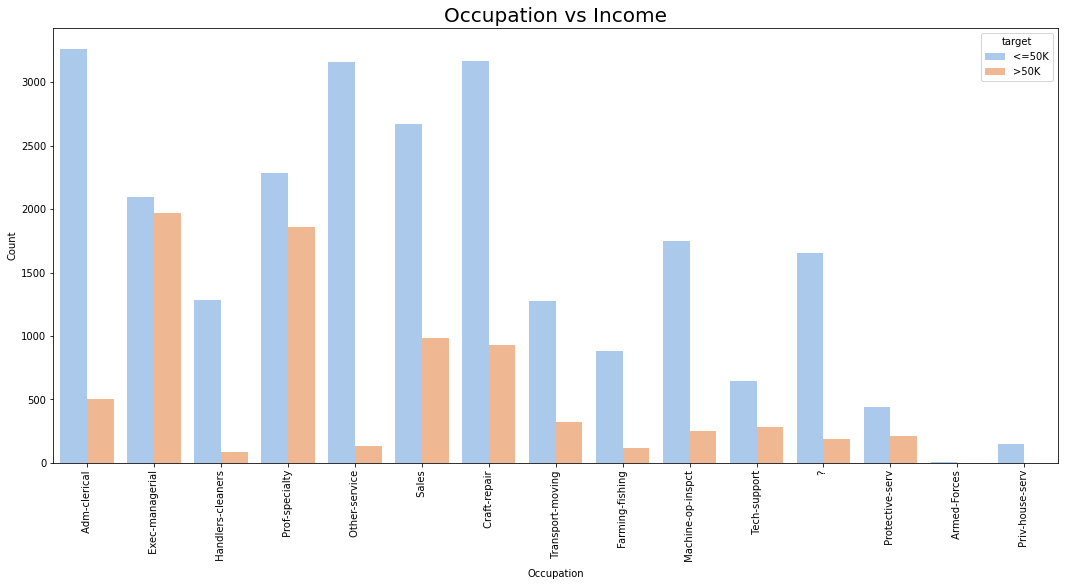

In [7]:
# select color
sns.set_palette('pastel')
# deterimne figure size
fig = plt.figure(figsize = (18,8))
ax=sns.countplot(training['ooccupation'], hue=training['target'])
# title
ax.set_title('Occupation vs Income', size=20)
plt.xlabel("Occupation",fontsize = 10)
plt.xticks(rotation=90)
plt.ylabel('Count');

Visualize `age` column as a groups 

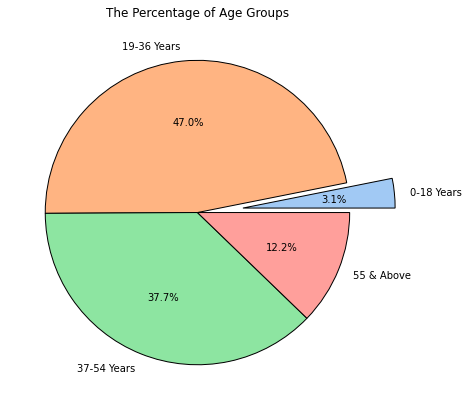

In [8]:
# select color
sns.set_palette('pastel')
# split age column into groups
age1 = training.loc[training.age <= 18].age.count()
age2 = training.loc[((training.age > 19)&(training.age <= 36))].age.count()
age3 = training.loc[((training.age > 37)&(training.age <= 54))].age.count()
age4 = training.loc[((training.age > 55)&(training.age <= 72))].age.count()
Age_list = [age1 , age2  , age3 , age4]
# deterimne figure size
plt.figure(figsize=[7,7])
plt.pie(Age_list, explode=[0.3,0,0,0], labels=['0-18 Years', '19-36 Years', '37-54 Years', '55 & Above' ] ,
        autopct='%1.1f%%',
              wedgeprops = {"edgecolor" : "black",
                      'linewidth': 1, 
                      'antialiased': True})
# title
plt.title("The Percentage of Age Groups");

Visualize number of stages of education by gender

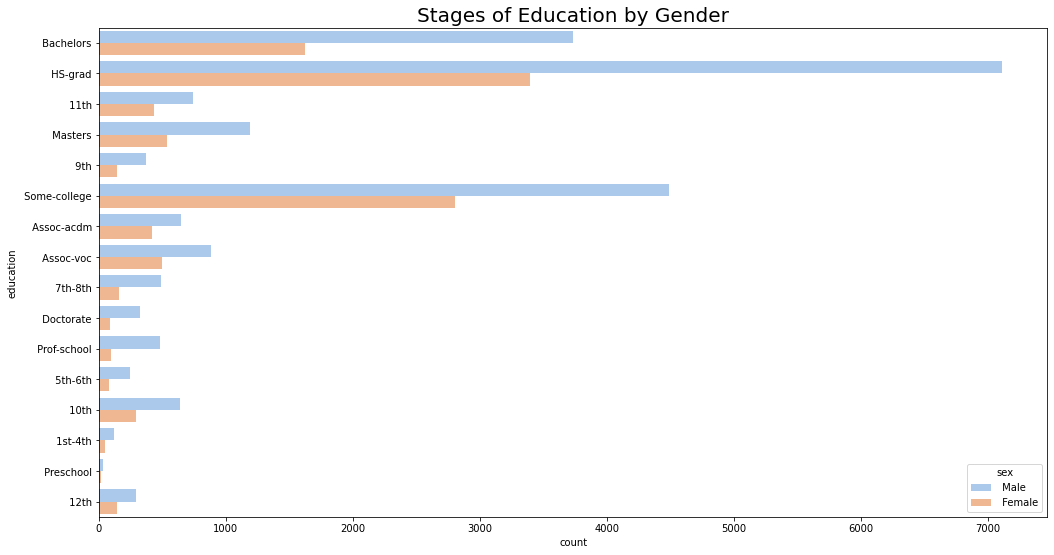

In [9]:
# select color
sns.set_palette('pastel')
# deterimne figure size
plt.figure(figsize=(17, 9))
sns.countplot(y='education', hue='sex', data=training )
plt.title("Stages of Education by Gender", size=20);

Visualize the relationship between `workclass` and `hours_per_week`

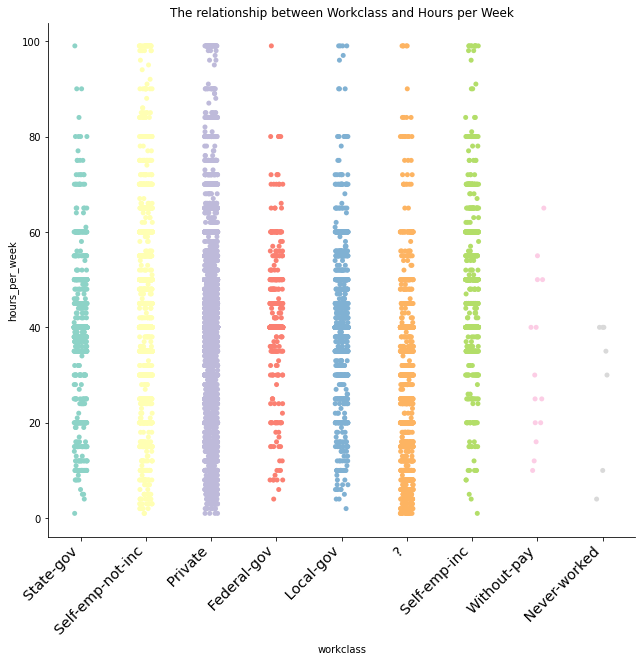

In [10]:
sns.set_palette('Set3')
g =sns.catplot(x = "workclass",y = "hours_per_week",data=training)
# deterimne figureheight and figurewidth size
g.fig.set_figheight(8)
g.fig.set_figwidth(10)
# title
plt.title( "The relationship between Workclass and Hours per Week") 
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large');

Visulaize the unique values in `relationship` column

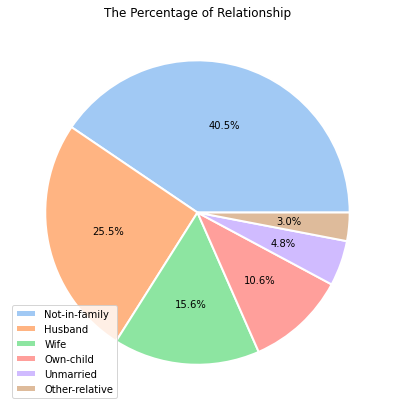

In [11]:
# select color
sns.set_palette('pastel')
# deterimne figure size
plt.figure(figsize=(7,7));
labels = ['Not-in-family', 'Husband', 'Wife', 'Own-child',
          'Unmarried', 'Other-relative']
plt.pie(training.relationship.value_counts(), autopct='%1.1f%%' ,
        wedgeprops = {"edgecolor" : "white", 
                      'linewidth': 2, 
                      'antialiased': True})
# title
plt.title("The Percentage of Relationship")
plt.legend(labels, loc ='lower left');

Visualize the relationship between `education_num` and `target`

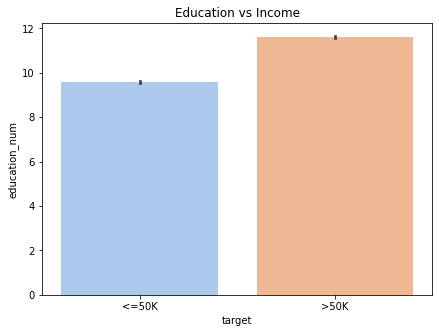

In [12]:
# deterimne figure size
plt.figure(figsize=(7,5))
sns.barplot(y='education_num', x='target', data=training)
# title
plt.title('Education vs Income');

## 2. Data prep & `train_test_split()`
    

Check if there is any missing values

In [13]:
training.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
ooccupation       0
relationship      0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
target            0
dtype: int64

Remove Abnprmal values from `native_country` column

In [14]:
training.drop(training.loc[training['native_country']==' ?'].index, inplace=True)

Convert `target` column from categorical to int

In [15]:
training['target']= training['target'].map({'<=50K':1, '>50K':0}).astype(int)
training.target

0        1
1        1
2        1
3        1
4        1
        ..
32556    1
32557    0
32558    1
32559    1
32560    0
Name: target, Length: 31978, dtype: int64

Display categorical columns

In [16]:
cat_col = [col for col in training.columns if training[col].dtype=='O']
cat_col

['workclass',
 'education',
 'marital_status',
 'ooccupation',
 'relationship',
 'sex',
 'native_country']

Convert `sex` column from categorical to int

In [17]:
training['sex'] = training['sex'].map({' Male':0, ' Female':1}).astype(int)

Save object columns in variable

In [18]:
categorical = training[cat_col]

Convert categorical columns into dummy/ indictor variables

In [19]:
categorical_dum = pd.get_dummies(categorical)

Concat new datafame with training dataset

In [20]:
df_new = pd.concat(
    [training,
     categorical_dum],
      axis=1)
df_new

,age,workclass,fnlwgt,education,education_num,marital_status,ooccupation,relationship,sex,capital_gain,capital_loss,hours_per_week,native_country,target,sex,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,...,native_country_ Canada,native_country_ China,native_country_ Columbia,native_country_ Cuba,native_country_ Dominican-Republic,native_country_ Ecuador,native_country_ El-Salvador,native_country_ England,native_country_ France,native_country_ Germany,native_country_ Greece,native_country_ Guatemala,native_country_ Haiti,native_country_ Holand-Netherlands,native_country_ Honduras,native_country_ Hong,native_country_ Hungary,native_country_ India,native_country_ Iran,native_country_ Ireland,native_country_ Italy,native_country_ Jamaica,native_country_ Japan,native_country_ Laos,native_country_ Mexico,native_country_ Nicaragua,native_country_ Outlying-US(Guam-USVI-etc),native_country_ Peru,native_country_ Philippines,native_country_ Poland,native_country_ Portugal,native_country_ Puerto-Rico,native_country_ Scotland,native_country_ South,native_country_ Taiwan,native_country_ Thailand,native_country_ Trinadad&Tobago,native_country_ United-States,native_country_ Vietnam,native_country_ Yugoslavia
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,0,2174,0,40,United-States,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,0,0,0,13,United-States,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,0,0,0,40,United-States,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,0,0,0,40,United-States,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,1,0,0,40,Cuba,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,1,0,0,38,United-States,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,0,0,0,40,United-States,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,1,0,0,40,United-States,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,0,0,0,20,United-States,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0

Drop categorical columns from dataframe

In [21]:
df_new.drop(['workclass',
 'education',
 'marital_status',
 'ooccupation',
 'relationship',
 'native_country'], axis=1, inplace=True)

## 3. Create a model
We used Classification model:
- KNeighborsClassifier
- LogisticRegression
- SGDClassifier


## 4. Optimization methods: 
**GridSearchCV** is a function that comes in Scikit-learn’s(or SK-learn) model_selection package. This function helps to loop through predefined hyperparameters and fit your estimator (model) on your training set. So, in the end, we can select the best parameters from the listed hyperparameters.

**RandomizedSearchCV** Random search is a technique where random combinations of the hyperparameters are used to find the best solution for the built model. It is similar to grid search, and yet it has proven to yield better results comparatively.



In [22]:
%time
# import train_test_split to split dataset
from sklearn.model_selection import train_test_split

X = df_new.drop(['target'], axis=1)
#X = df_new[['relationship_ Husband', 'marital_status_ Married-civ-spouse', 'marital_status_ Never-married','education_num', 'age', 'hours_per_week']]
y = df_new.target

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


In [23]:
# import standard scaler
from sklearn.preprocessing import StandardScaler
# import standard scaler
from sklearn.model_selection import RandomizedSearchCV


In [24]:
#Standardize features by removing the mean and scaling to unit variance
sc = StandardScaler()



### Model 1
## **KNeighborsClassifier:**

In [25]:
# import KNN model
from sklearn.neighbors import KNeighborsClassifier

In [26]:
#Compute the mean and std to be used for later scaling
X_train = sc.fit_transform(X_train)
#Fit to data, then transform it.
X_test = sc.transform(X_test)

In [27]:
knn = KNeighborsClassifier(leaf_size=2, n_neighbors=9, metric='minkowski', p=1, n_jobs=-1)

knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=9, p=1,
                     weights='uniform')

In [28]:
# prediction for X_test
%%time
pred_knn = knn.predict(X_test)

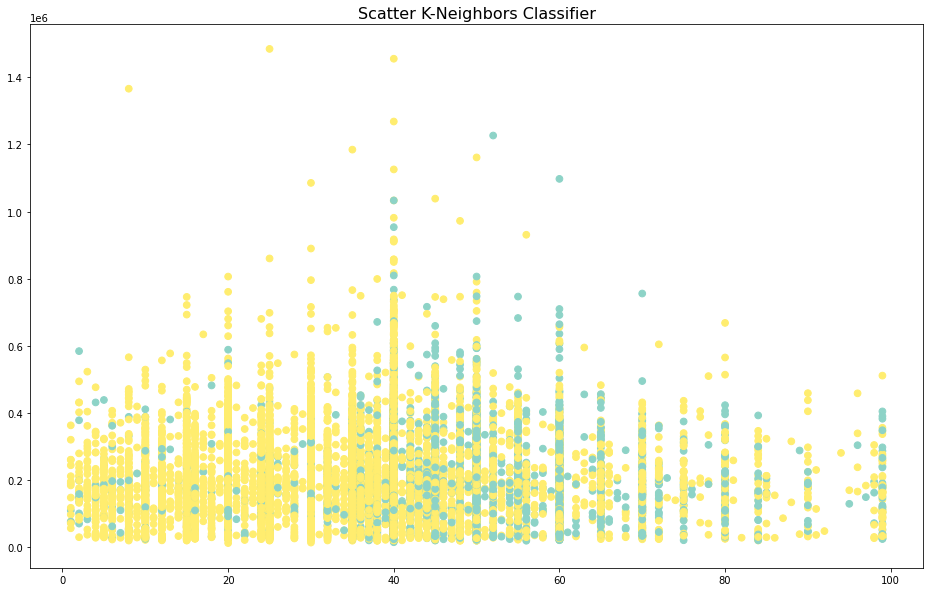

In [93]:
# deterimne figure size
plt.figure(figsize=(16,10))
plt.scatter(x=df_new['hours_per_week'], y=df_new['fnlwgt'],
            c=df_new['target'], cmap=('Set3'),  s = 45)
# title
plt.title('Scatter K-Neighbors Classifier', fontsize=16);

Visualization Confusion Matrix

CPU times: user 3min 42s, sys: 65.7 ms, total: 3min 42s
Wall time: 56.5 s


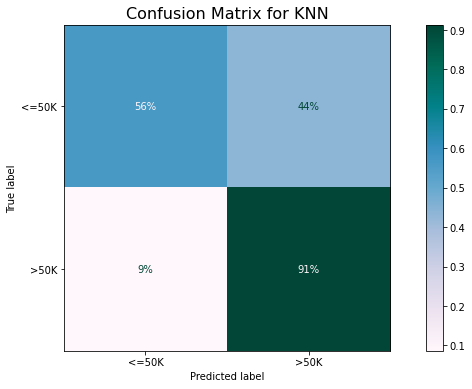

In [30]:
%%time 
# deterimne figure size
fig, ax = plt.subplots(figsize=(13, 6))
# title
plt.title('Confusion Matrix for KNN', fontsize=16)
# make confusion matrix
plot_confusion_matrix(knn, X=X_test, y_true=y_test, cmap='PuBuGn', ax=ax, display_labels=['<=50K', '>50K'], normalize='true', values_format='.0%');

In [31]:
#print accuracy for KNN
print("KNN Accuracy is {:.2f}%".format(accuracy_score(y_test, pred_knn)*100))

KNN Accuracy is 82.92%


## LogisticRegression Optimization with RandomizedSearchCV:



In [32]:
#RandomizedSearchCV parameters
param_grid = {'n_neighbors':[9,10,11,12],'weights': ['uniform', 'distance']}

In [33]:
#applying RandomizedSearchCV in KNN model
random_reg = RandomizedSearchCV(knn,param_grid,n_iter=15,n_jobs=-1,cv=5)

In [34]:
#fit traoning dato into RandomizedSearchCV
 %%time
 random_reg.fit(X_train,y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=15. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


CPU times: user 1.64 s, sys: 84.1 ms, total: 1.73 s
Wall time: 16min 37s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=KNeighborsClassifier(algorithm='auto', leaf_size=2,
                                                  metric='minkowski',
                                                  metric_params=None, n_jobs=-1,
                                                  n_neighbors=9, p=1,
                                                  weights='uniform'),
                   iid='deprecated', n_iter=15, n_jobs=-1,
                   param_distributions={'n_neighbors': [9, 10, 11, 12],
                                        'weights': ['uniform', 'distance']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [35]:

#outcomes of RandomizedSearchCV in KNN to find best parameters and score
%%time
RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                                        n_neighbors=9, p=1,
                                        weights='uniform'),iid='warn', n_iter=15, n_jobs=-1,
                   param_distributions={'n_neighbors': [9, 10, 11, 12], 'weights': ['uniform', 'distance']})

CPU times: user 32 µs, sys: 0 ns, total: 32 µs
Wall time: 35 µs


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=9,
                                                  p=1, weights='uniform'),
                   iid='warn', n_iter=15, n_jobs=-1,
                   param_distributions={'n_neighbors': [9, 10, 11, 12],
                                        'weights': ['uniform', 'distance']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [36]:
#RandomizedSearchCV in KNN to find best parameters
random_reg.best_estimator_


KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=11, p=1,
                     weights='uniform')

In [37]:
#RandomizedSearchCV in KNN to find best score
random_reg.best_score_

0.8325140830015313

**KNN Report:**

In [38]:
# calculate the performance metrics for knn
classification_report(y_test, pred_knn)

'              precision    recall  f1-score   support\n\n           0       0.67      0.56      0.61      2305\n           1       0.87      0.91      0.89      7289\n\n    accuracy                           0.83      9594\n   macro avg       0.77      0.74      0.75      9594\nweighted avg       0.82      0.83      0.82      9594\n'

### Model 2:
## **LogisticRegression :**

In [39]:
# import Logistic Regression model
from sklearn.linear_model import LogisticRegression

In [40]:
# logistic regression is a classifier, for our case, True (1) or False (0)
lr = LogisticRegression()

In [41]:
#fit training set into LogisticRegression model 
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
# predict the y values from X test data
pred_lr = lr.predict(X_test)

In [43]:
#cross val score
from sklearn.model_selection import cross_val_score
cross_val_score(lr, X_train, y_train, cv=10)

array([0.85037963, 0.8673515 , 0.8530594 , 0.85841894, 0.84271671,
       0.85835567, 0.84986595, 0.86058981, 0.84182306, 0.84271671])

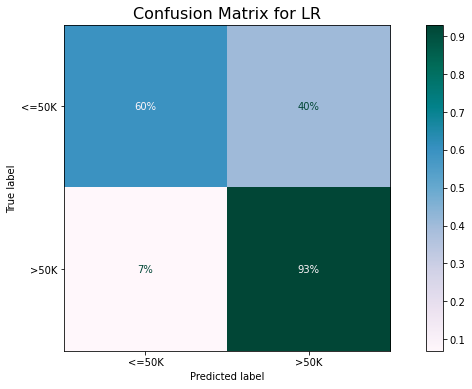

In [44]:
# deterimne figure size
fig, ax = plt.subplots(figsize=(13, 6))
# title
plt.title('Confusion Matrix for LR', fontsize=16)
# make confusion matrix
plot_confusion_matrix(lr, X=X_test, y_true=y_test, cmap='PuBuGn', ax=ax, display_labels=['<=50K', '>50K'], normalize='true', values_format='.0%');

In [45]:
# print accuracy for SGDC
print("Logistics Regression Accuracy is {:.2f}%".format(accuracy_score(y_test, lr.predict(X_test))*100))

Logistics Regression Accuracy is 85.03%


## LogisticRegression Optimization with RandomizedSearchCV:



In [46]:
#RandomizedSearchCV parameters  for logisticregresssion
log_params = {'penalty': ['l1','l2'],
              'C': [0.001,0.01,0.1,0.5,1.0],
              'class_weight': ['balanced',None],
              'multi_class': ['auto', 'ovr'],
              'solver': ['newton-cg', 'lbfgs']
             }

In [47]:
#RandomizedSearchCV for logisticregresssion with previous parameters 
random_reg = RandomizedSearchCV(lr,log_params,n_jobs=-1,cv=10)

In [48]:
#fit training set into RandomizedSearchCV
random_reg.fit(X_train,y_train)


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 0.5, 1.0],
                                        'class_weight': ['balanced', None],
                                        'multi_class': ['auto', 'ovr'],
                                        'penalty': ['l1', '

In [49]:
#RandomizedSearchCV's best parameters for LogisticRegression
random_reg.best_estimator_


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
#RandomizedSearchCV's best score for LogisticRegression
random_reg.best_score_


0.8518577368215816

## Check out the accuracy of LogisticRegression model after using RandomizedSearchCV optimization:

In [51]:
#hyperparameters of LogisticRegression
lr = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
#fit rainig set into LogisticRegression after RandomizedSearchCV
lr.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
#prediction of X_test 
pred_lr = lr.predict(X_test)


In [54]:
#Accuracy of Logistics Regression
print("Logistics Regression Accuracy is {:.2f}%".format(accuracy_score(y_test, lr.predict(X_test))*100))

Logistics Regression Accuracy is 85.04%


## LogisticRegression Optimization with GridSearchCV:

In [55]:
param_grid ={'solver': ['liblinear', 'newton-cg'],
             'fit_intercept':[True, False]}
#Make GridSearchCV
grid_search =GridSearchCV(lr, param_grid, cv=10)

In [56]:
#fit X_train and y_train into grid_search
grid_search= grid_search.fit(X_train, y_train)
grid_search

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=0.1, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'fit_intercept': [True, False],
                         'solver': ['liblinear', 'newton-cg']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [57]:
#best parameters of LogisticRegression after using GridSearchCV
grid_search.best_params_

{'fit_intercept': True, 'solver': 'liblinear'}

In [58]:
#best score of LogisticRegression after using GridSearchCV
grid_search.best_score_

0.852706489596043

## Check out the accuracy of LogisticRegression model after using GridSearchCV's optimization:

In [59]:
#LogisticRegression with best parameters
lr=LogisticRegression(fit_intercept= True, solver= 'liblinear')

In [60]:
#fit training set into LogisticRegression
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [61]:
#prediction of x_test
pred_lr = lr.predict(X_test)

In [62]:
print("LogisticRegression Accuracy after using GridSearchCV is {:.2f}%".format(accuracy_score(y_test, lr.predict(X_test))*100))

LogisticRegression Accuracy after using GridSearchCV is 85.03%


LogisticRegression Report: 

In [63]:
# calculate the performance metrics for logistics regression
classification_report(y_test, pred_lr)

'              precision    recall  f1-score   support\n\n           0       0.73      0.60      0.66      2305\n           1       0.88      0.93      0.90      7289\n\n    accuracy                           0.85      9594\n   macro avg       0.81      0.76      0.78      9594\nweighted avg       0.84      0.85      0.84      9594\n'

### Model 3:
##  **Stochastic Gradient Descent:**

In [64]:
# import SGD Classifier model
from sklearn.linear_model import SGDClassifier

In [65]:
sgdc = SGDClassifier(max_iter=1000)

In [66]:
#fit training set into SGD model
sgdc.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [67]:
#prediction of X_test
pred_sgdc = sgdc.predict(X_test)

In [68]:
# print accuracy for SGDC
print("Stochastic Gradient Descent Accuracy is {:.2f}%".format(accuracy_score(y_test, pred_sgdc)*100))

Stochastic Gradient Descent Accuracy is 84.07%


Stochastic Gradient Descent Report:

In [69]:
# calculate the performance metrics for sgdc
classification_report(y_test, pred_sgdc)

'              precision    recall  f1-score   support\n\n           0       0.71      0.57      0.63      2305\n           1       0.87      0.93      0.90      7289\n\n    accuracy                           0.84      9594\n   macro avg       0.79      0.75      0.77      9594\nweighted avg       0.83      0.84      0.83      9594\n'

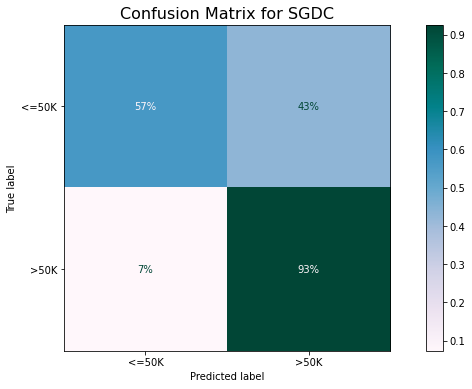

In [70]:
# deterimne figure size
fig, ax = plt.subplots(figsize=(13, 6))
# title
plt.title('Confusion Matrix for SGDC', fontsize=16)
# make confusion matrix
plot_confusion_matrix(sgdc, X=X_test, y_true=y_test, cmap='PuBuGn', ax=ax, display_labels=['<=50K', '>50K'], normalize='true', values_format='.0%');


## Stochastic Gradient Descent Optimization with RandomizedSearchCV:

 

In [71]:
#param_grid = {'n_neighbors':[9,10,11,12],'weights': ['uniform', 'distance']}

sgdc_params = {'loss': ['log', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
              'max_iter': [10, 100, 250, 1000, 10000],
               'penalty':['l2', 'l1']}

In [72]:
#optimize SGDClassifier by RandomizedSearchCV
random_reg = RandomizedSearchCV(sgdc,sgdc_params,n_jobs=-1,cv=10)


In [73]:
%%time
#fit training set into RandomizedSearchCV
random_reg.fit(X_train,y_train)


CPU times: user 6.37 s, sys: 38.5 ms, total: 6.41 s
Wall time: 1min 4s


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=1000,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=None, shuffle=True,
                                           tol=0.001, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'

In [74]:
# best patamers of SGDClassifier after using RandomizedSearchCV
random_reg.best_estimator_

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [75]:
# best score of SGDClassifier after using RandomizedSearchCV
random_reg.best_score_


0.8505619968700122

## Check out the accuracy of SGDClassifier model after using RandomizedSearchCV optimization:

In [76]:
sgdc = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=100,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [77]:
#fit trainig set into SGDClassifier after using RandomizedSearchCV
sgdc.fit(X_train, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=100,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [78]:
#prediction of x_test 
pred_sgdc = sgdc.predict(X_test)

In [79]:
#accuracy of Stochastic Gradient Descent
print("Stochastic Gradient Descent Accuracy after using RandomizedSearchCV optimization is {:.2f}%".format(accuracy_score(y_test, pred_sgdc)*100))

Stochastic Gradient Descent Accuracy after using RandomizedSearchCV optimization is 84.98%


## Stochastic Gradient Descent Optimization with GridSearchCV:

In [80]:
from sklearn.model_selection import GridSearchCV
#GridSearchCV optimization for Stochastic Gradient Descent model 
param_dict = {'loss': ['log', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
              'max_iter': [1000, 10000]}

grid_sgdc = GridSearchCV(sgdc, param_dict)
grid_sgdc

GridSearchCV(cv=None, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='log', max_iter=100,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l1', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'loss': ['log', 'huber', 'epsilon_insensitive',
                                  'squared_epsilon_insensitive'],
                         'max_iter': [1000, 10000]},
             pre_

In [81]:
#fit X_train and y_train into grid_search
%%time
grid_sgdc.fit(X_train, y_train)

CPU times: user 1min 20s, sys: 14.4 s, total: 1min 34s
Wall time: 1min 18s


GridSearchCV(cv=None, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='log', max_iter=100,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l1', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'loss': ['log', 'huber', 'epsilon_insensitive',
                                  'squared_epsilon_insensitive'],
                         'max_iter': [1000, 10000]},
             pre_

In [83]:
#sgdc best parameters after the GridSearchCV optimization
grid_sgdc.best_params_

{'loss': 'log', 'max_iter': 10000}

In [84]:
#sgdc best score after the GridSearchCV optimization
grid_sgdc.best_score_

0.8497581821734881

## Check out the accuracy of SGDClassifier model after using GridSearchCV optimization:

In [85]:
#SGDClassifier with best parameters after using GridSearchCV
sgdc=SGDClassifier(loss= 'log', max_iter= 10000)

In [86]:
#fit training set into sgdc
sgdc.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log',
              max_iter=10000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [87]:
#prediction of X_test
pred_sgdc = sgdc.predict(X_test)

In [88]:
print("Stochastic Gradient Descent Accuracy after using GridSearchCV optimization is {:.2f}%".format(accuracy_score(y_test, pred_sgdc)*100))

Stochastic Gradient Descent Accuracy after using GridSearchCV optimization is 84.52%


## 5. Baseline model:

Baseline is a model that is both simple to set up and has a reasonable chance of providing decent results. Experimenting with them is usually quick and low cost, since implementations are widely available in popular packages.

  

In [89]:
# function baseline
def baseline_model(n_predictions, value_to_predict):
    """
    just predict a single value (e.g. mean) for everything
    """
    # create array to save predictions
    baseline_preds = []
    # loop to add baseline predictions in array baseline_preds
    for i in range(n_predictions):
        baseline_preds.append(value_to_predict)
    # return predictions
    return pd.Series(baseline_preds)

In [90]:
n_predictions = len(y_test)  # how many predictions to make?
baseline_value = y_train.value_counts().index[0]  # what value to predict? 
# make predictions baseline
baseline_preds = baseline_model(n_predictions, baseline_value)
baseline_preds

0       1
1       1
2       1
3       1
4       1
       ..
9589    1
9590    1
9591    1
9592    1
9593    1
Length: 9594, dtype: int64

In [91]:
# baseline accuracy
baseline_acc = accuracy_score(y_test, baseline_preds)
print("Baseline Accuracy is {:.2f}%".format(baseline_acc*100))

Baseline Accuracy is 75.97%


In [92]:
# report for y_test and preds
print(classification_report(y_test, pred_knn))

              precision    recall  f1-score   support

           0       0.67      0.56      0.61      2305
           1       0.87      0.91      0.89      7289

    accuracy                           0.83      9594
   macro avg       0.77      0.74      0.75      9594
weighted avg       0.82      0.83      0.82      9594



5. Optimize your model
    - [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
        - Bonus: [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
    - Compare your results to the baseline
        - How did you do this? Why?
    - If you don't beat the baseline, try improving your model or using a different model
        - Were you able to beat the baseline? Why?

# Comparison between classification models accuracy:


In [94]:
# create empty array
models = []
# add models in array
models.append(('LogisticRegression', LogisticRegression()))
models.append(('SGDClassifier', SGDClassifier()))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))

In [95]:
# create 2 empty array to append results and names for models
results = []
names = []
# determine type scoring
scoring = 'accuracy'
# loop to 
for name, model in models:
  kfold = model_selection.KFold(n_splits=10, random_state=None)
  cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LogisticRegression: 0.852394 (0.008236)
SGDClassifier: 0.841851 (0.008307)
KNeighborsClassifier: 0.824517 (0.009114)


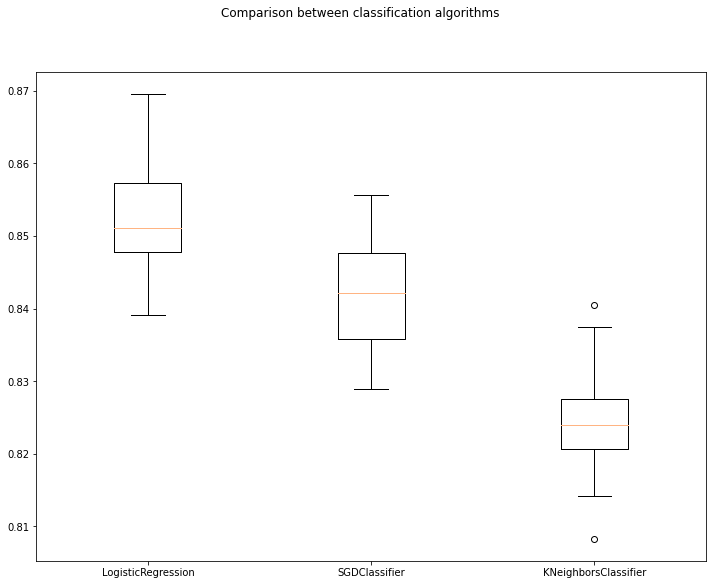

In [97]:
# determine figure size
fig = plt.figure(figsize=(12,9))
# title
fig.suptitle('Comparison between classification algorithms')
ax = fig.add_subplot(111)
# create boxplot
plt.boxplot(results)
ax.set_xticklabels(names)
# show plot
plt.show()

## ROC and AUC for SGDClassifier, KNeighborsRegressor, and LogisticRegression ( SGDC, KNN, LR) :

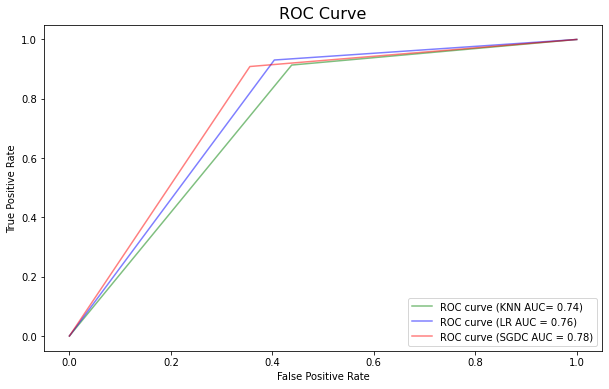

In [98]:
# import libraries roc_curve and area under curve
from sklearn.metrics import roc_curve, auc

# calculate roc curve
false_positive_rate_knn, true_positive_rate_knn, thresholds_knn = roc_curve(y_test, pred_knn)
false_positive_rate_lr, true_positive_rate_lr, thresholds_lr = roc_curve(y_test, pred_lr)
false_positive_rate_sgdc, true_positive_rate_sgdc, thresholds_sgdc = roc_curve(y_test, pred_sgdc)


# calculate area under curve 
roc_auc_knn = auc(false_positive_rate_knn, true_positive_rate_knn)
roc_auc_lr = auc(false_positive_rate_lr, true_positive_rate_lr)
roc_auc_sgdc = auc(false_positive_rate_sgdc, true_positive_rate_sgdc)

# figure size
plt.figure(figsize=(10,6))
# plot roc curve
plt.plot(false_positive_rate_knn, true_positive_rate_knn, color='green', alpha=0.5, label='ROC curve (KNN AUC= %0.2f)' % roc_auc_knn)
plt.plot(false_positive_rate_lr, true_positive_rate_lr, color='blue', alpha=0.5, label='ROC curve (LR AUC = %0.2f)' % roc_auc_lr)
plt.plot(false_positive_rate_sgdc, true_positive_rate_sgdc, color='red', alpha=0.5, label='ROC curve (SGDC AUC = %0.2f)' % roc_auc_sgdc)


# add labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# add title and specific location of legend
plt.title('ROC Curve', fontsize=16)
# show the plot
plt.legend(loc="lower right")
plt.show()



# Conclusion:

To conclude, we obtain `KNeighborsClassifier`, `LogisticRegression`, `SGDClassifier` recorded accuracy with `83.0%`, `85.03%`, and `84.52%`respectively after using `GridSearchCV` and `RandomizedSearchCV`. As we have seen above with no significant difference among them.

To compare these models with the `Baseline`, we illustrate that. Baseline showed the lowest accuracy with `75.97%`.

From the previous chart, the Area Under Curve (AUC) for `LogisticRegression` model LR is showing the best choice rather than `K-Nearest Neighbors` algorithm KNN.

## Resources:
* [K-Nearest Neighbors](https://www.analyticsvidhya.com/blog/2015/08/learning-concept-knn-algorithms-programming/)
* [Logistic Regression](https://searchbusinessanalytics.techtarget.com/definition/logistic-regression)
* [SGD Classifier](https://www.tutorialspoint.com/scikit_learn/scikit_learn_stochastic_gradient_descent.htm)
* [Baseline](https://blog.insightdatascience.com/always-start-with-a-stupid-model-no-exceptions-3a22314b9aaa)
* [GridSearchCV](https://www.mygreatlearning.com/blog/gridsearchcv/)
* [RandomizedSearchCV](https://scikit-learn.org/0.16/modules/generated/sklearn.grid_search.RandomizedSearchCV.html)
* [Difference between GridSearchCV and RandomizedSearchCV](https://www.linkedin.com/pulse/what-gridsearchcv-randomizedsearchcv-differences-between-cheruku)
* [Comparing Machine Learning Methods](https://pythondata.com/comparing-machine-learning-methods/)

**We tried some plot of KNN**

In [ ]:
#%%time
# # creating list of K for KNN
# k_list = list(range(1,50,2))
# # creating list of cv scores
# cv_scores = []

# # perform 10-fold cross validation
 #for k in k_list:
   #  knn = KNeighborsClassifier(n_neighbors=k)
  #   scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    # cv_scores.append(scores.mean())

# # changing to misclassification error
# MSE = [1 - x for x in cv_scores]

 #plt.figure()
 #plt.figure(figsize=(15,10))
 #plt.title('The optimal number of neighbors', fontsize=20, fontweight='bold')
 #plt.xlabel('Number of Neighbors K', fontsize=15)
 #plt.ylabel('Misclassification Error', fontsize=15)
 #sns.set_style("whitegrid")
 #plt.plot(k_list, MSE)

 #plt.show();

In [ ]:
# error_rate = []
# # Might take some time
# for i in range(1,40):
    
#     knn = KNeighborsClassifier(n_neighbors=i)
#     knn.fit(X_train,y_train)
#     pred_i = knn.predict(X_test)
#     error_rate.append(np.mean(pred_i != y_test))

# plt.figure(figsize=(10,6))
# plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
#          markerfacecolor='red', markersize=10)
# plt.title('Error Rate vs. K Value')
# plt.xlabel('K')
# plt.ylabel('Error Rate')

**In this part, we tried to use GridSerach for finding best parameters, and it consumed a long time to run:**





In [ ]:
# #List Hyperparameters that we want to tune.
# leaf_size = list(range(1,30))
# n_neighbors = list(range(1,10))
# p=[1,2]
# #Convert to dictionary
# hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
# #Use GridSearch
# clf = GridSearchCV(knn, hyperparameters, cv=10)
# #Fit the model
# best_model = clf.fit(X,y)
# #Print The value of best Hyperparameters
# print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
# print('Best p:', best_model.best_estimator_.get_params()['p'])
# print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])